In [1]:
import pandas as pd

# get the data and print the head
df = pd.read_excel("COVID_BRAZIL.xlsx")
df.head()

,regiao,estado,municipio,coduf,codmun,codRegiaoSaude,nomeRegiaoSaude,data,semanaEpi,populacaoTCU2019,casosAcumulado,casosNovos,obitosAcumulado,obitosNovos,Recuperadosnovos,emAcompanhamentoNovos
0,Brasil,NaN,NaN,76,NaN,NaN,NaN,2020-02-25,9,210147125,0,0,0,0,NaN,NaN
1,Brasil,NaN,NaN,76,NaN,NaN,NaN,2020-02-26,9,210147125,1,1,0,0,NaN,NaN
2,Brasil,NaN,NaN,76,NaN,NaN,NaN,2020-02-27,9,210147125,1,0,0,0,NaN,NaN
3,Brasil,NaN,NaN,76,NaN,NaN,NaN,2020-02-28,9,210147125,1,0,0,0,NaN,NaN
4,Brasil,NaN,NaN,76,NaN,NaN,NaN,2020-02-29,9,210147125,2,1,0,0,NaN,NaN


In [86]:
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from math import sqrt
import numpy as np
import pandas as pd
from fbprophet import Prophet
import matplotlib.pyplot as plt

# constants
TESTING_DAYS = 16 # how many days that will be used to verify the accuracy of the data

# metrics
def mean_absolute_percentage_error(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

def root_mean_square_error(y_true, y_pred):
    return sqrt(mean_squared_error(y_true, y_pred))

def run_analysis(actual, predicted, state, test_type):
        # MAPE:
        mape = mean_absolute_percentage_error(actual, predicted)
        # MAD
        mad = mean_absolute_error(actual, predicted)
        # RMSE
        rmse = root_mean_square_error(actual, predicted)
        
        results = {"MAPE": mape, "MAD": mad, "RMSE": rmse, "State": state, "Test Type": test_type}
        results_series = pd.Series(results)
        
        return results_series
        

# Facebook Prophet Model For Brazilian States
def run_prophet_state(df, state):
    def _clean_data(df, state):
        if state == "BRAZIL": # takes care of the case of analyzing Brazil rather than a single state
            df1 = df[df["estado"].isnull()] 
        else:
            df1 = df.query("(municipio != municipio) and (estado == '%s')" % state)
            
        # removes bad data
        prev_row = 0
        for index, row in df1.iterrows():
            if (row["casosAcumulado"] < prev_row): # accumulated cases cannot decrease
                df1 = df1.drop(index, axis = 0 )
            else:
                prev_row = row["casosAcumulado"]
        return df1
    
    def _setup_data(df):
        # split into training and testing data
        training_df = df[:len(df) - TESTING_DAYS]
        testing_df = df[len(df) - TESTING_DAYS: len(df)]
        
        # setup training data to have required columns for prophet
        prophet_df = training_df[["data", "casosAcumulado"]]
        prophet_df = prophet_df.rename(columns = {"data": "ds", "casosAcumulado" : "y"})
        
        # get only the accumulated cases to compare later
        prophet_test = testing_df[["casosAcumulado"]]
        
        return prophet_df, prophet_test
    
    def _prophet_forecast(data):
        # run prediction
        m.fit(data)
        future = m.make_future_dataframe(periods = TESTING_DAYS)
        prophet_forecast = m.predict(future)
        prophet_forecast_df = prophet_forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']]
        return prophet_forecast, prophet_forecast_df
    
    
        
    m = Prophet()
    
    # clean up and setup the data
    clean_df = _clean_data(df, state)
    prophet_df, prophet_test = _setup_data(clean_df)
    forecast, prophet_forecast_df = _prophet_forecast(prophet_df)
    
    # clean up the results and analyze (results need to be reversed in order to match up with the test data)
    prophet_results = prophet_forecast_df[len(clean_df) - TESTING_DAYS:len(clean_df)]
    prophet_results_yhat = run_analysis(prophet_test, (prophet_results.iloc[::-1])[["yhat"]], state, "yhat")
    prophet_results_lower = run_analysis(prophet_test, (prophet_results.iloc[::-1])[["yhat_lower"]], state, "yhat_lower")
    prophet_results_upper = run_analysis(prophet_test, (prophet_results.iloc[::-1])[["yhat_upper"]], state, "yhat_upper")
    
    # create data frame with results from all predictions
    results_df = pd.DataFrame()
    results_df = results_df.append(prophet_results_yhat, ignore_index = True)
    results_df = results_df.append(prophet_results_lower, ignore_index = True)
    results_df = results_df.append(prophet_results_upper, ignore_index = True)
    
    # Setup main graphic
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize = (20, 10))
        
    # Forecast vs actual graph
    ax = prophet_forecast_df[:len(clean_df)].plot("ds", 'yhat', ax = axes[0])
    prophet_forecast_df[:len(clean_df)].plot("ds", "yhat_upper", ax = ax)
    prophet_forecast_df[:len(clean_df)].plot("ds", "yhat_lower", ax = ax)
    clean_df.plot("data", "casosAcumulado", ax=ax)  
    
    # Prophet Graph
    ax1 = m.plot(forecast, ax = axes[1])    
    
    # Finalize formatting
    fig.suptitle("%s Graphs" % state, fontsize = 20)
    axes[0].set_title("Predictions vs Actual", fontsize = 16)
    axes[1].set_title("Prophet Graph", fontsize = 16)
    fig.tight_layout()
    fig.subplots_adjust(top=0.88)
    
    # output to file
    fig.savefig("results\plots\%s plots.png" % state)
    return results_df
    


    


   

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seaso

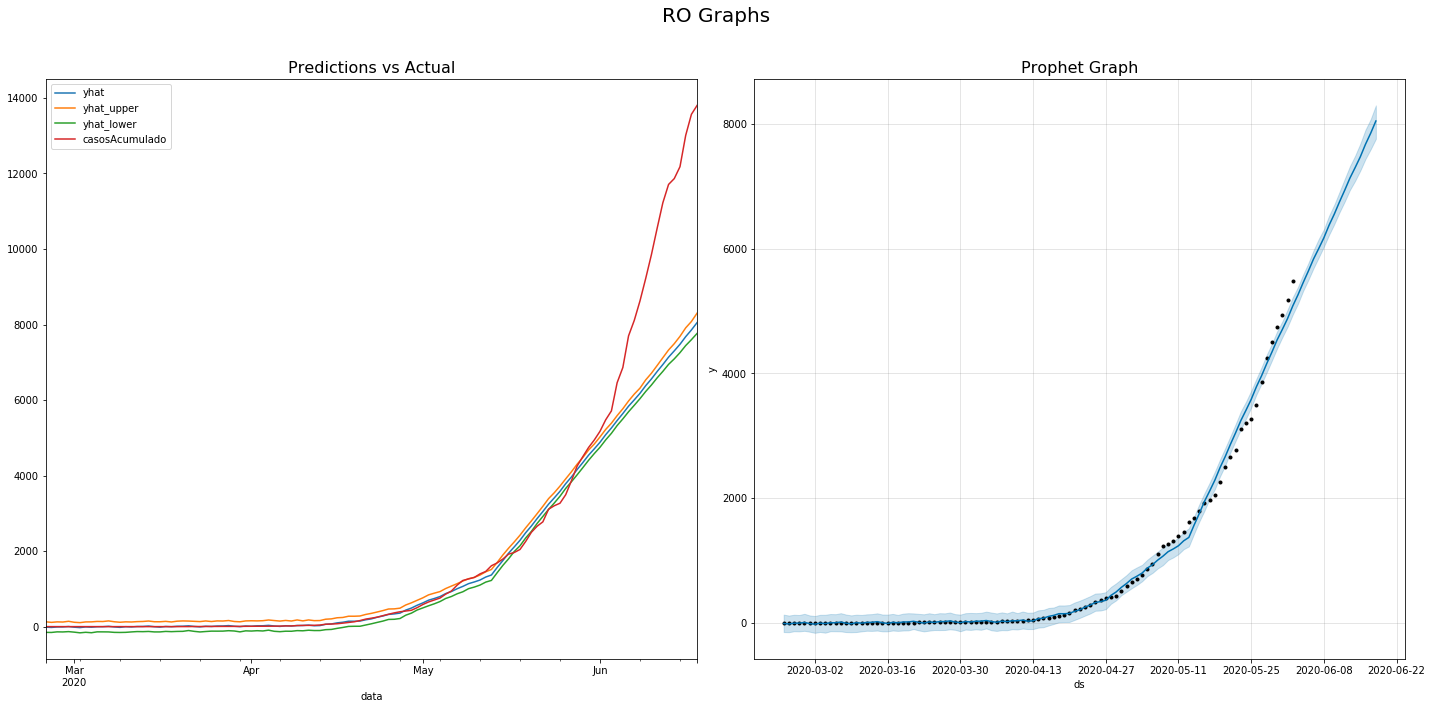

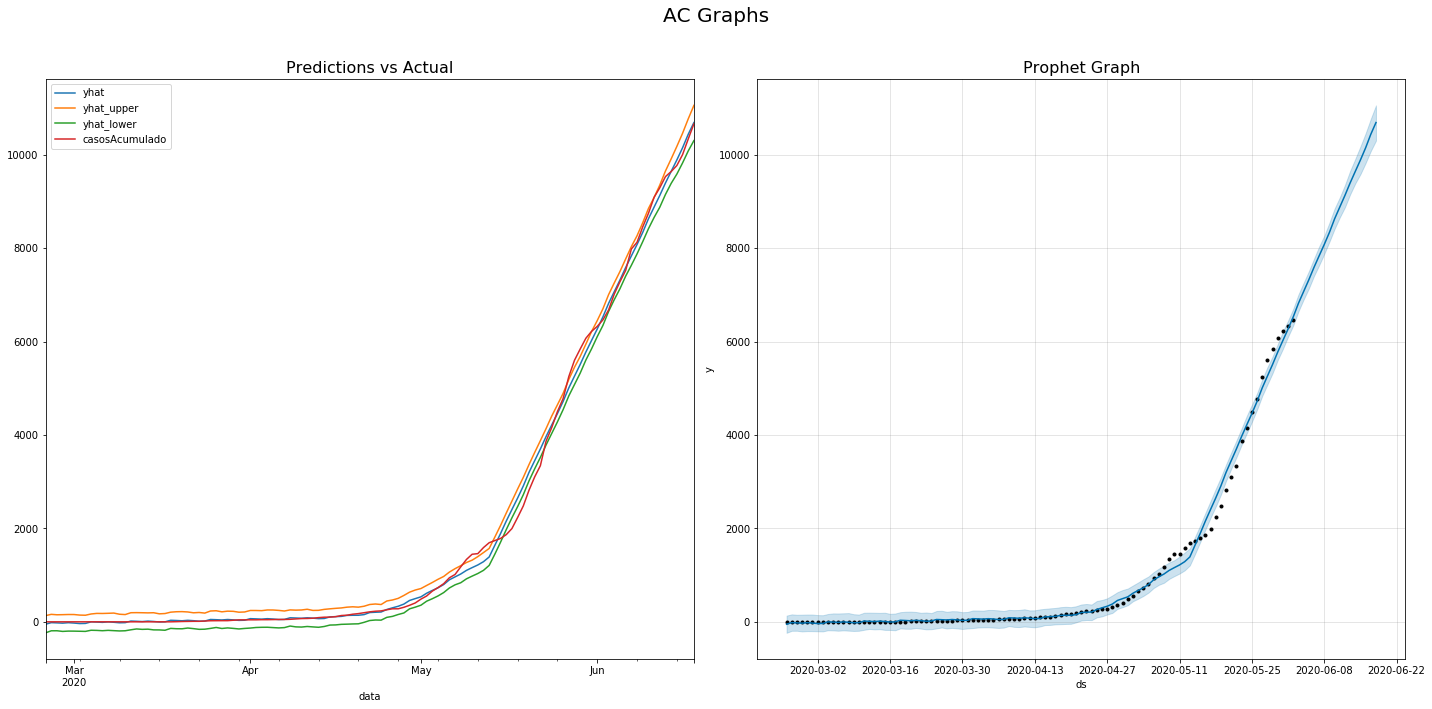

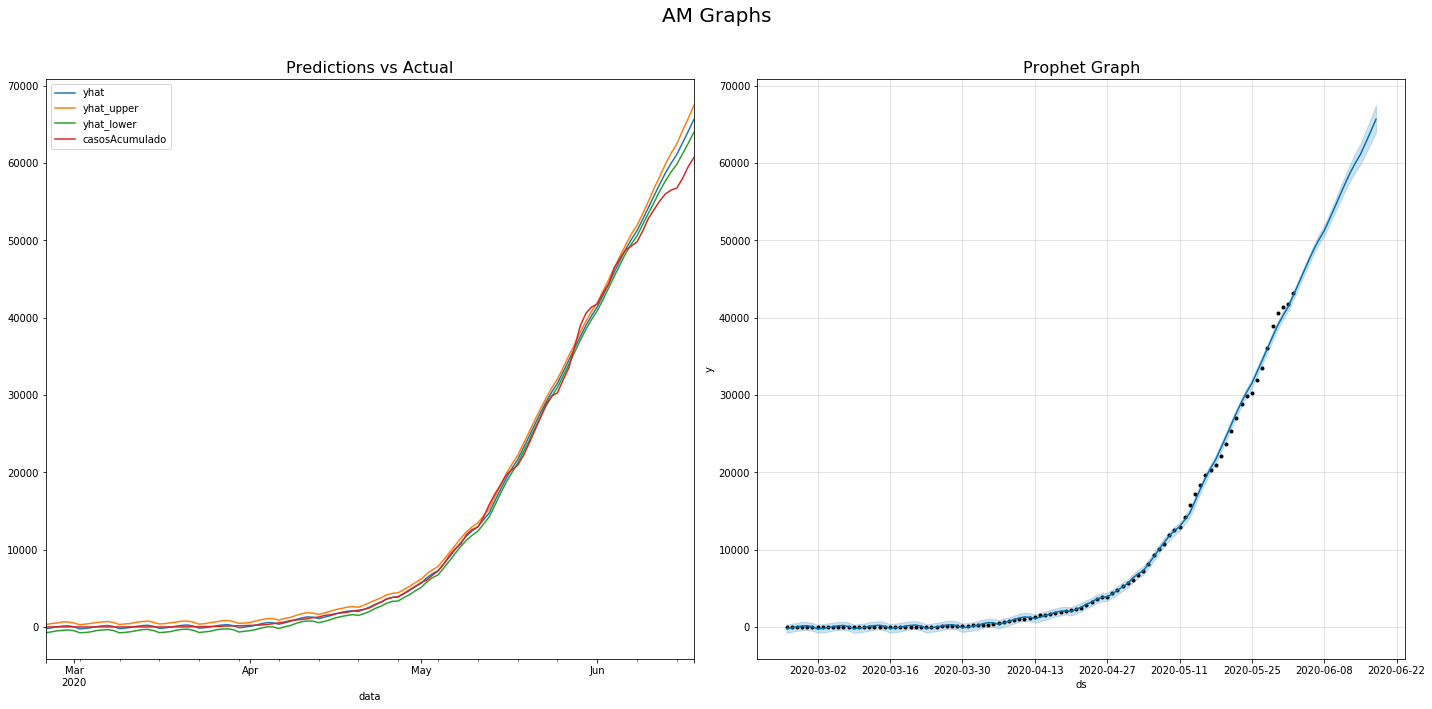

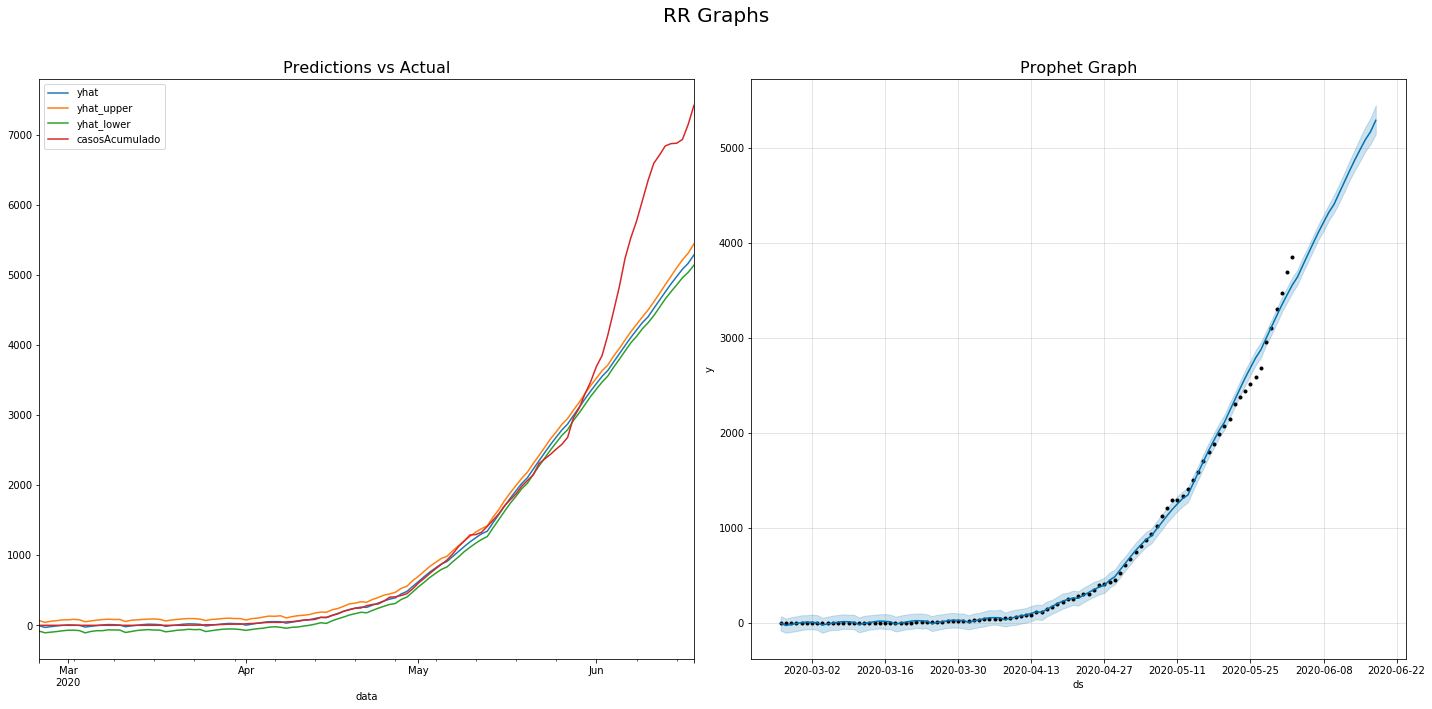

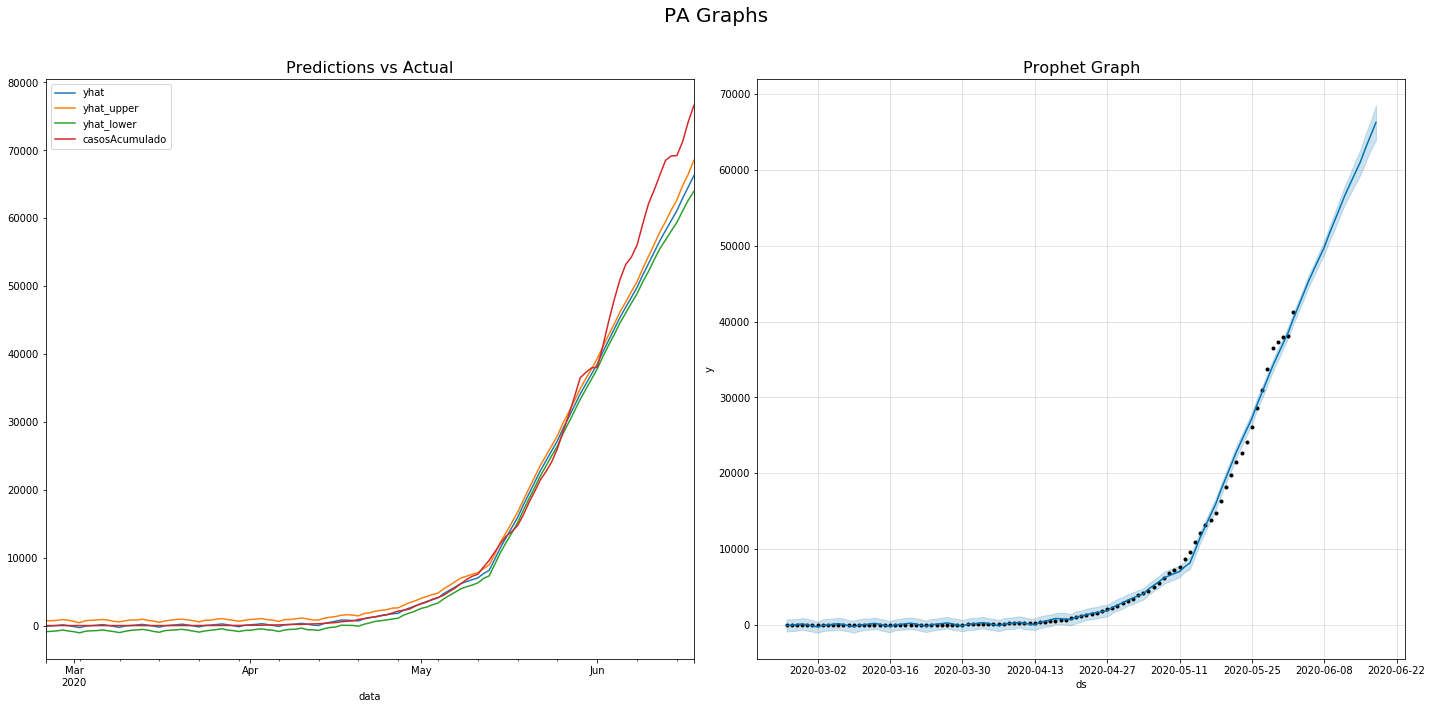

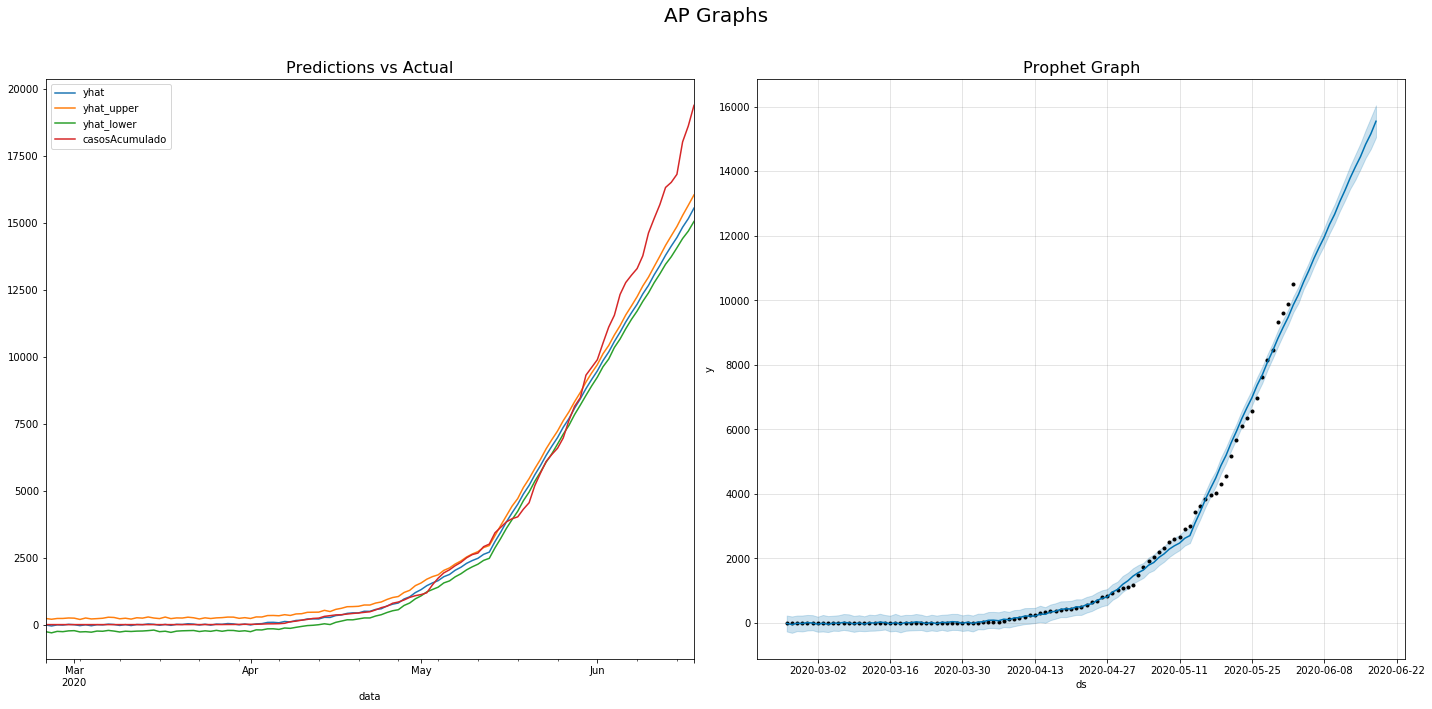

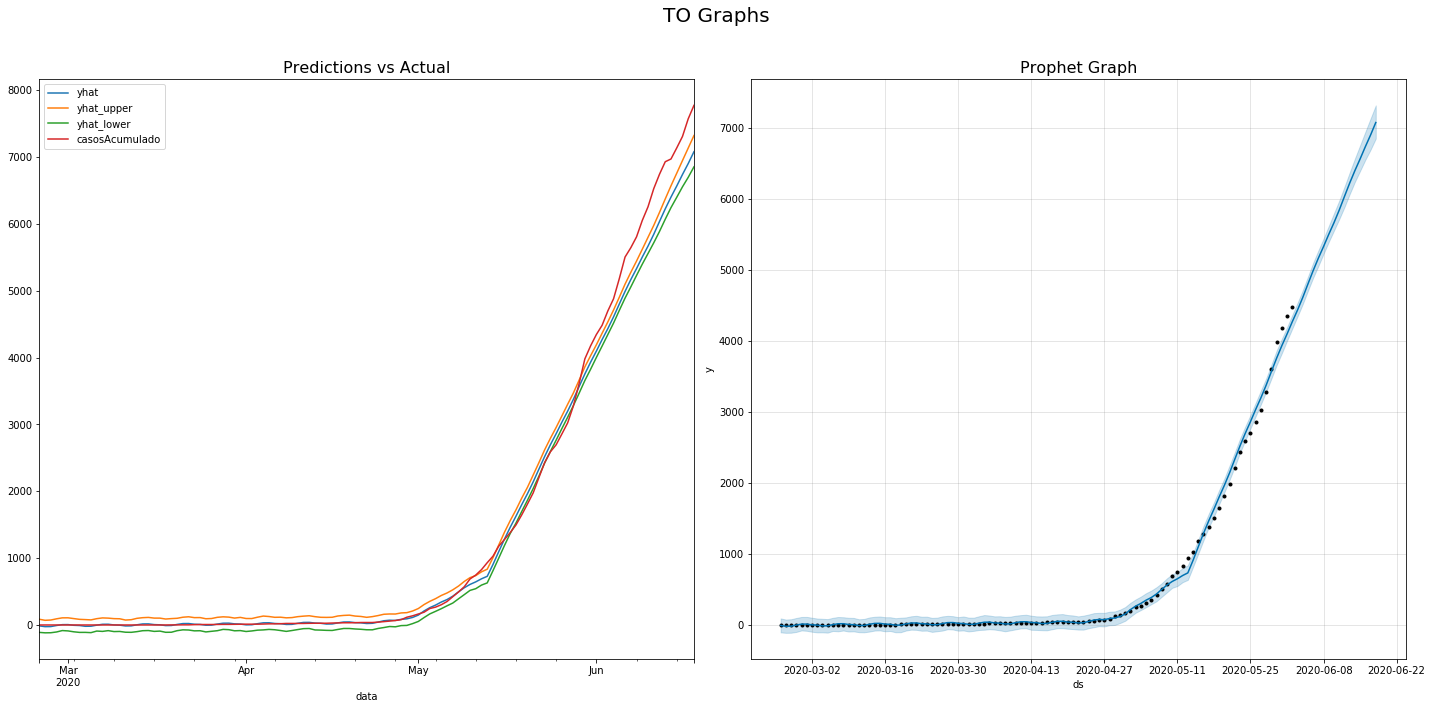

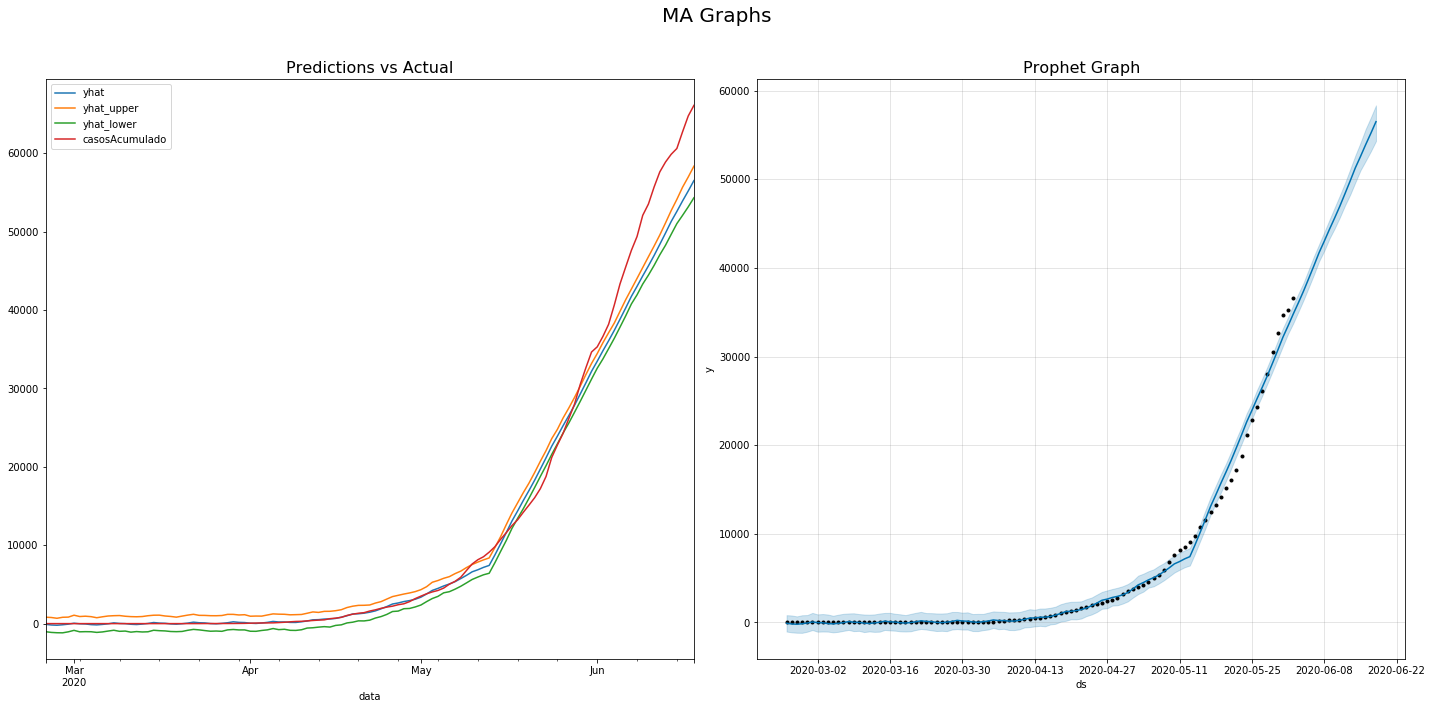

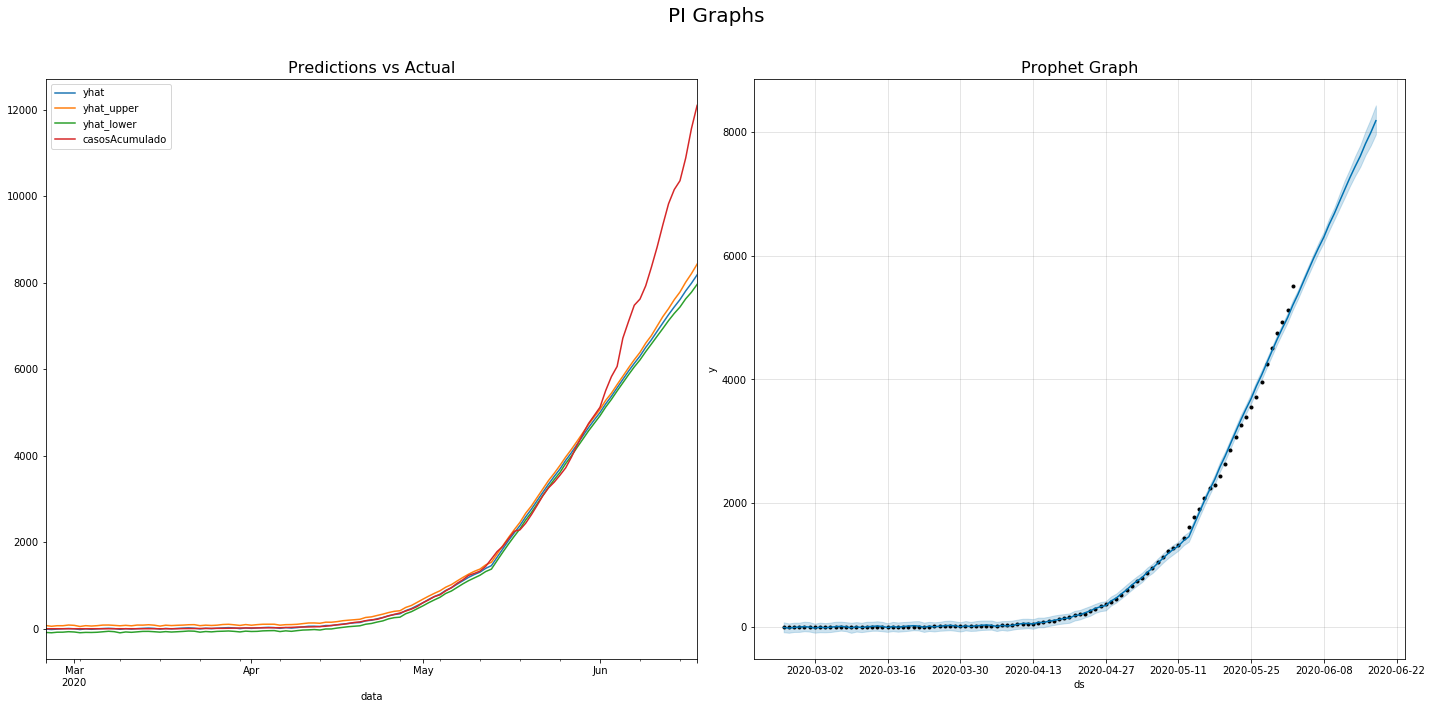

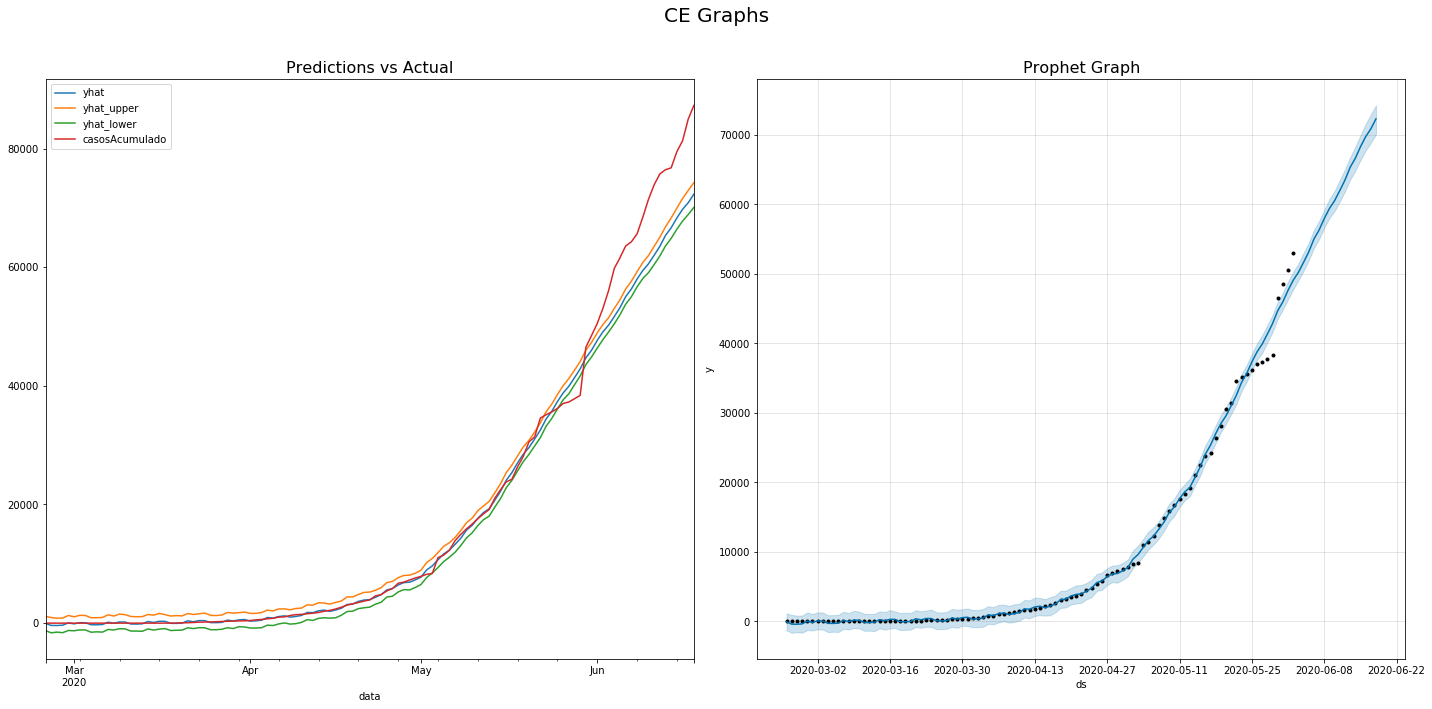

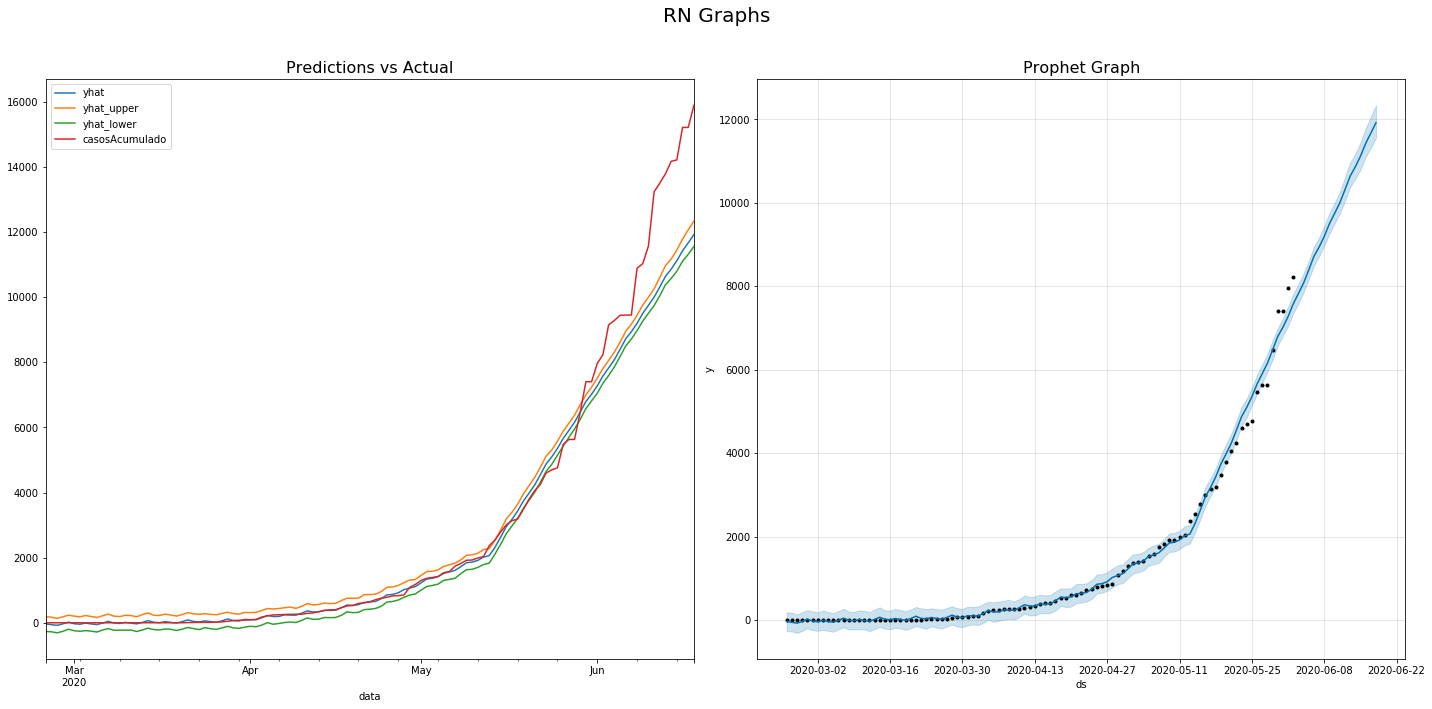

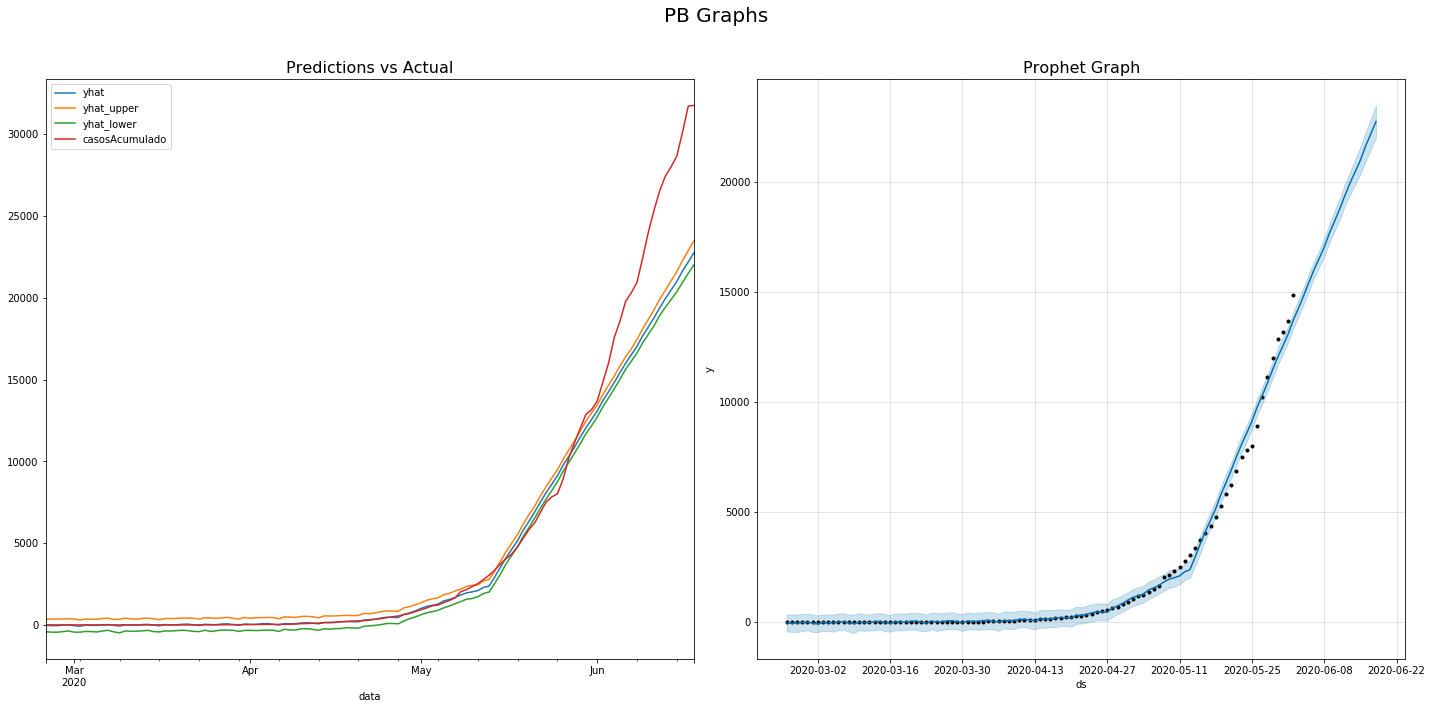

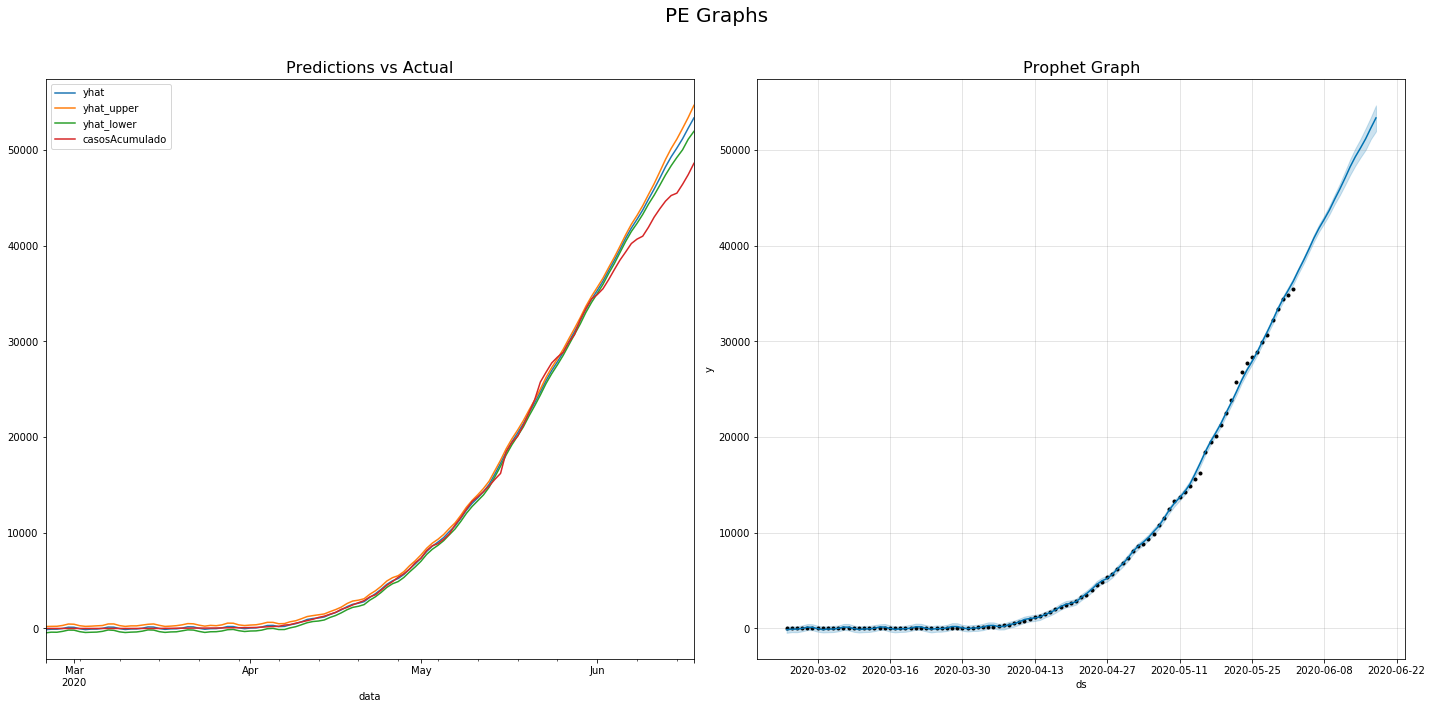

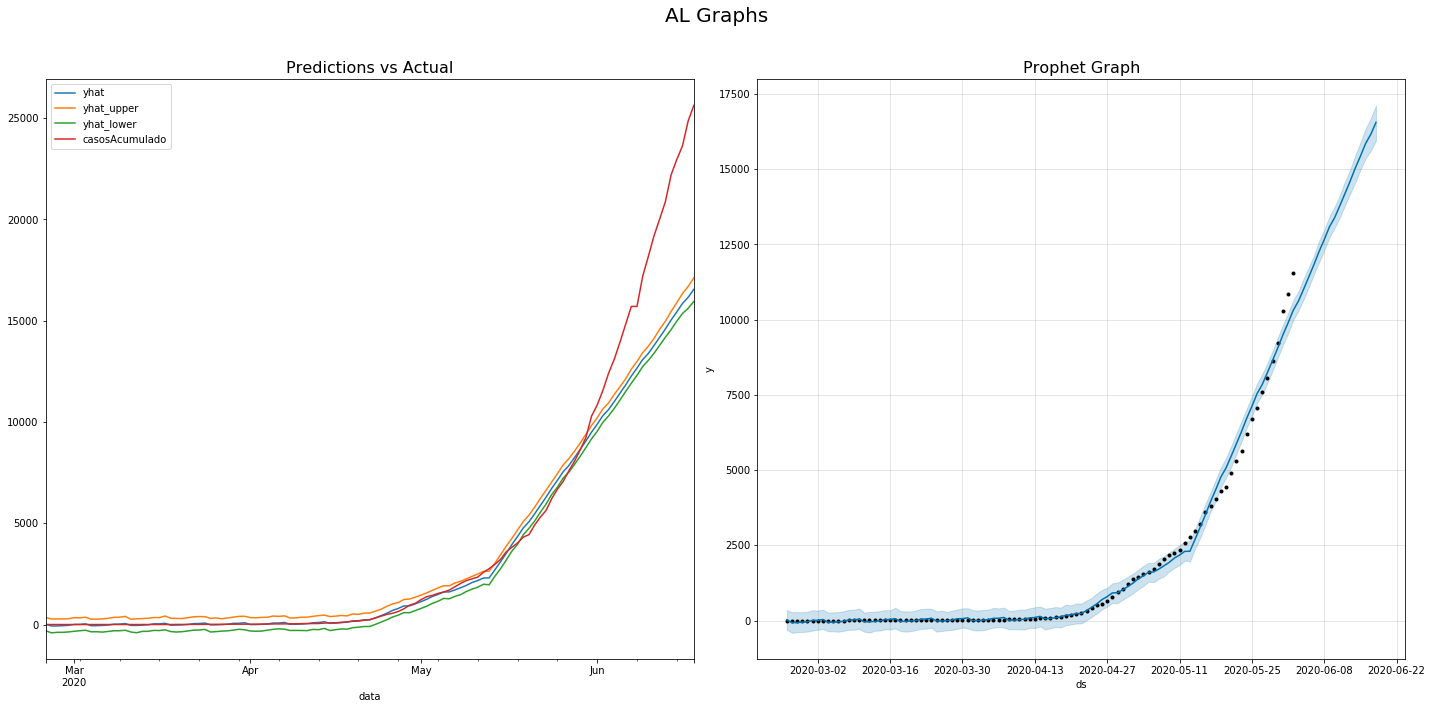

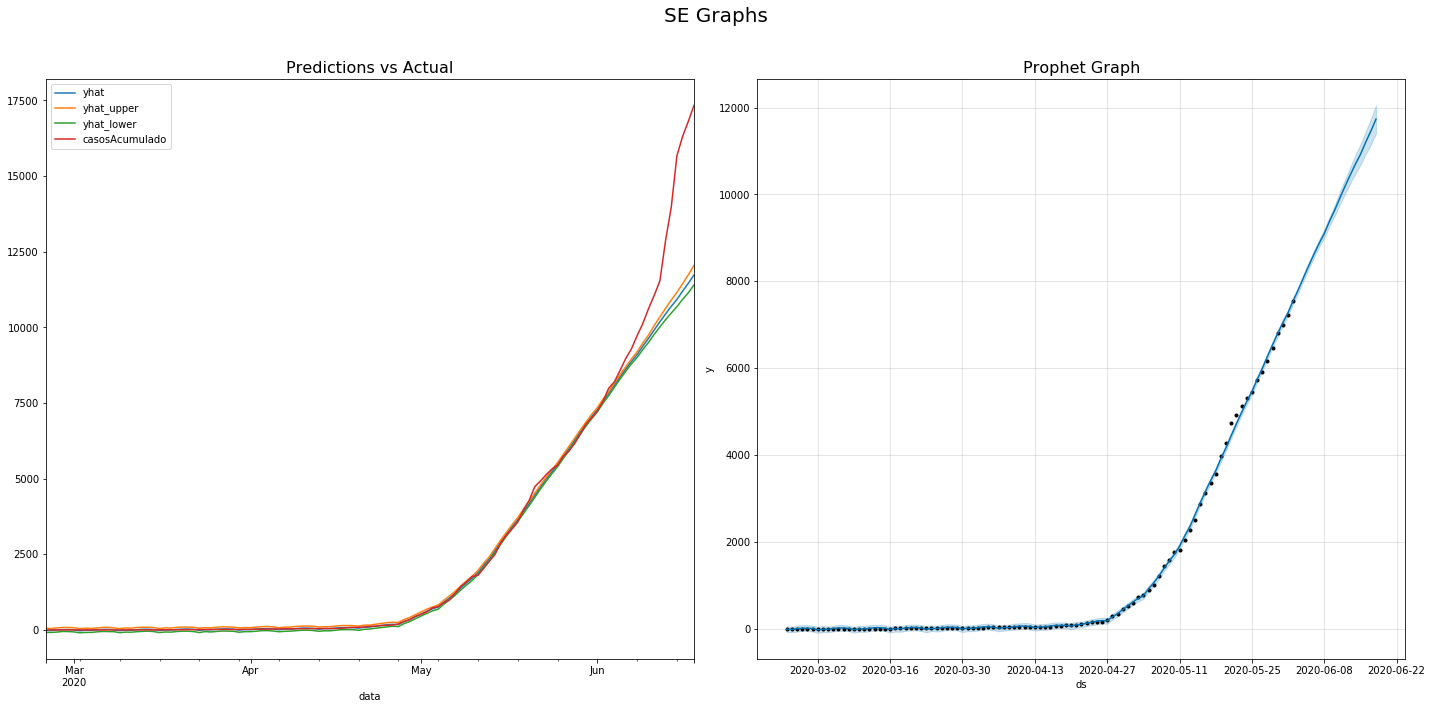

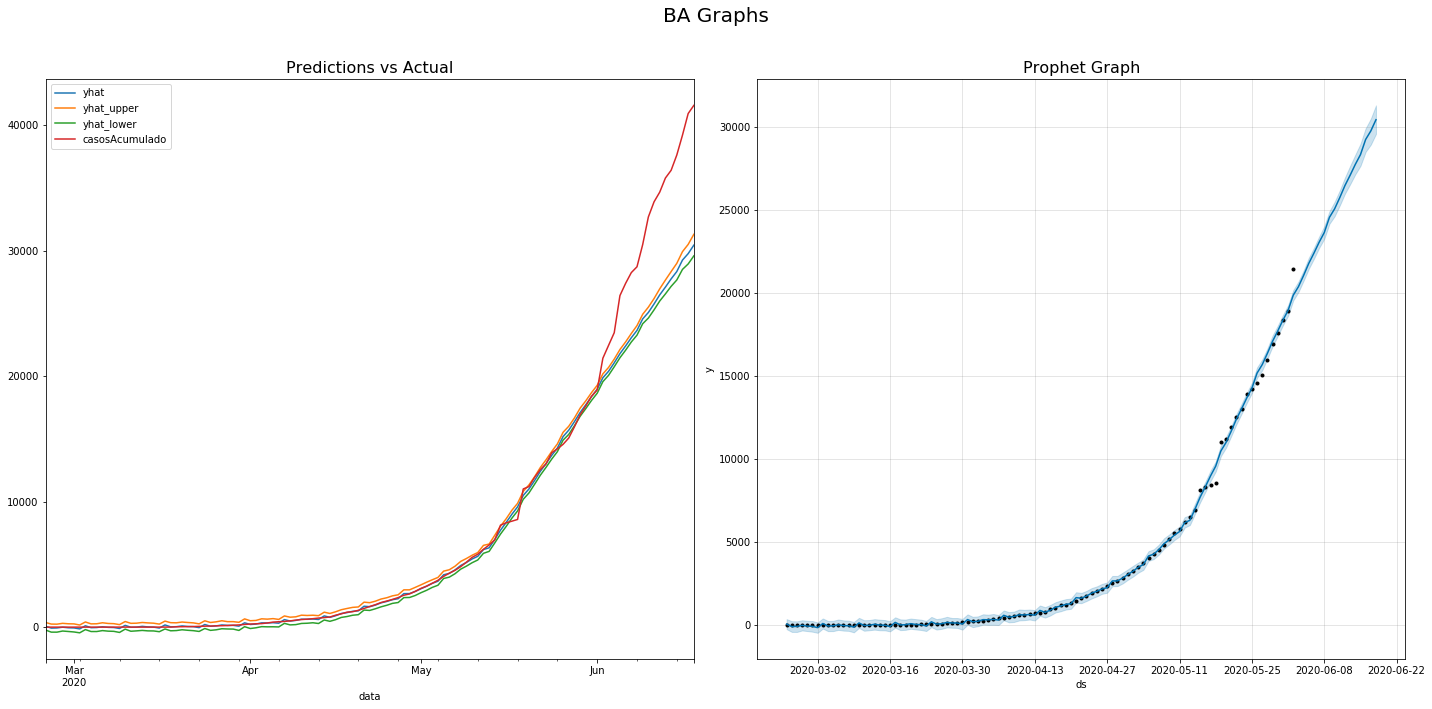

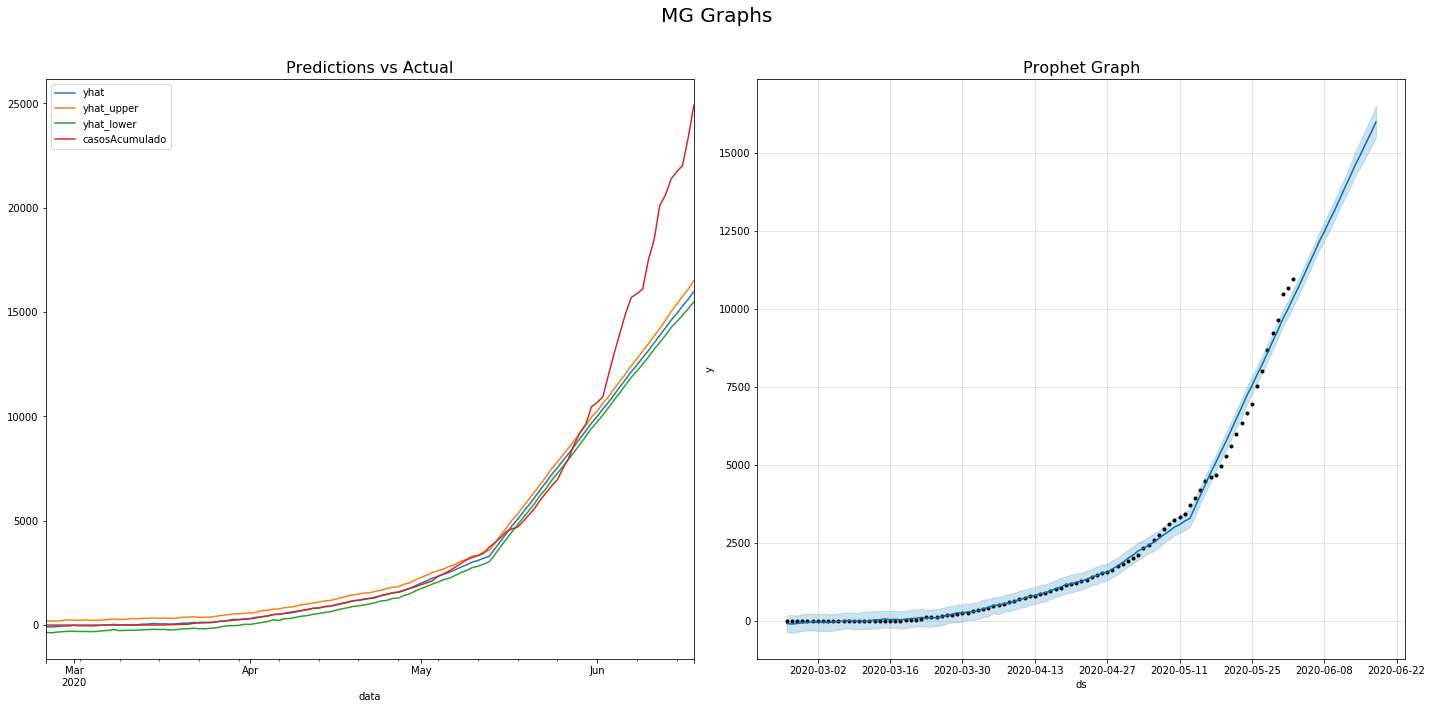

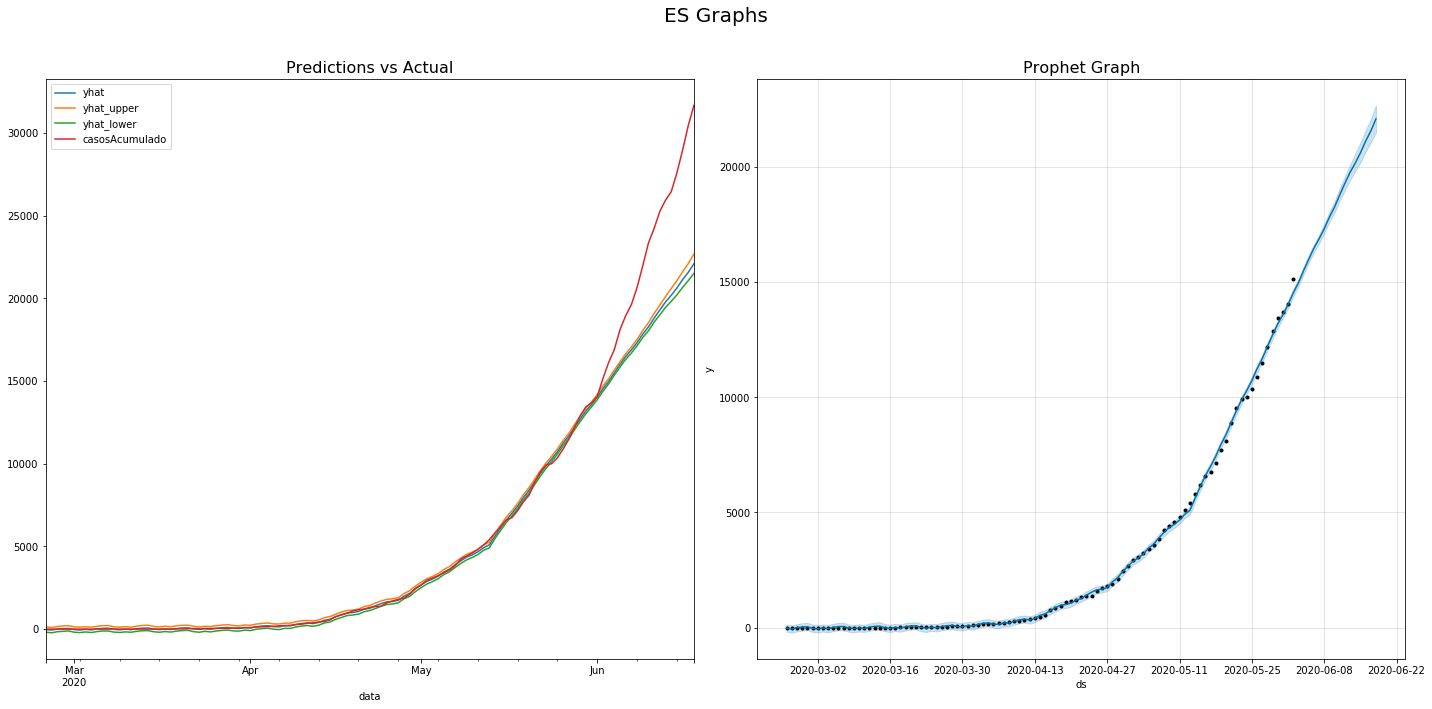

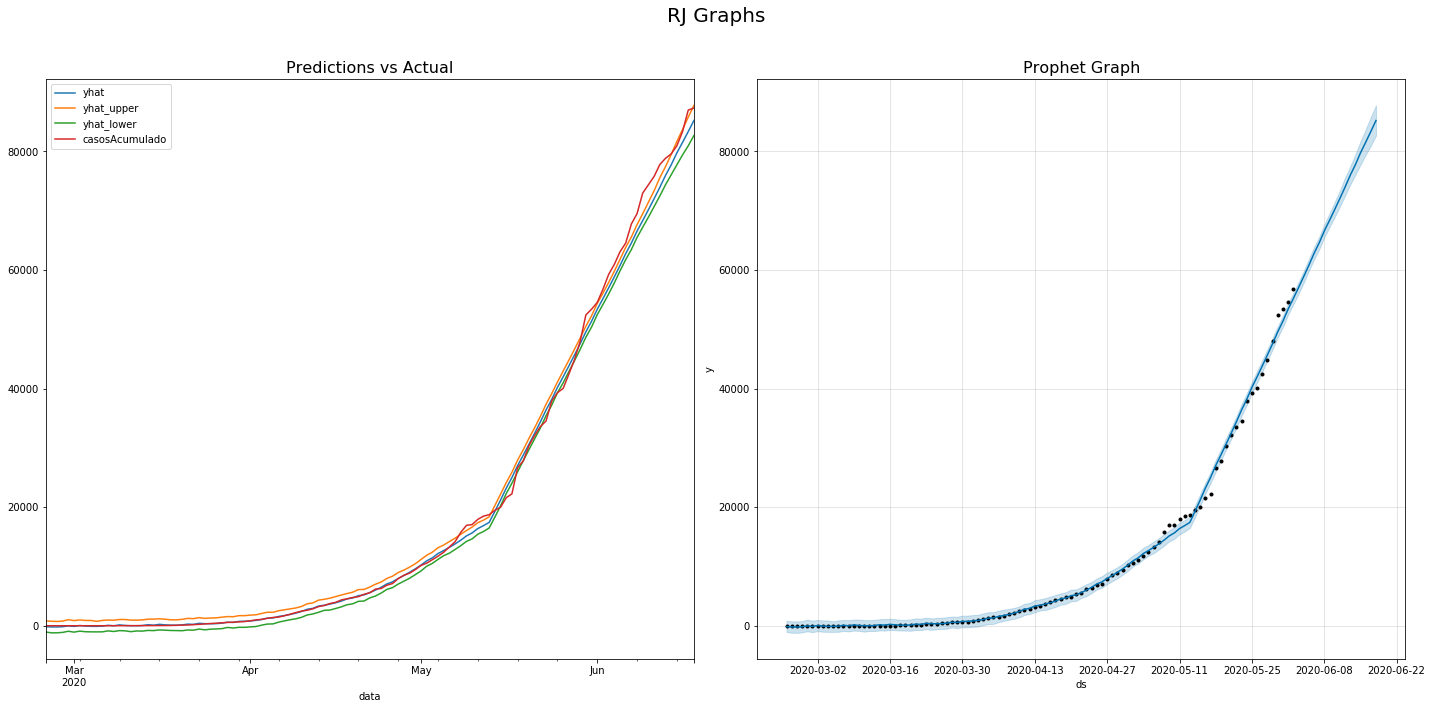

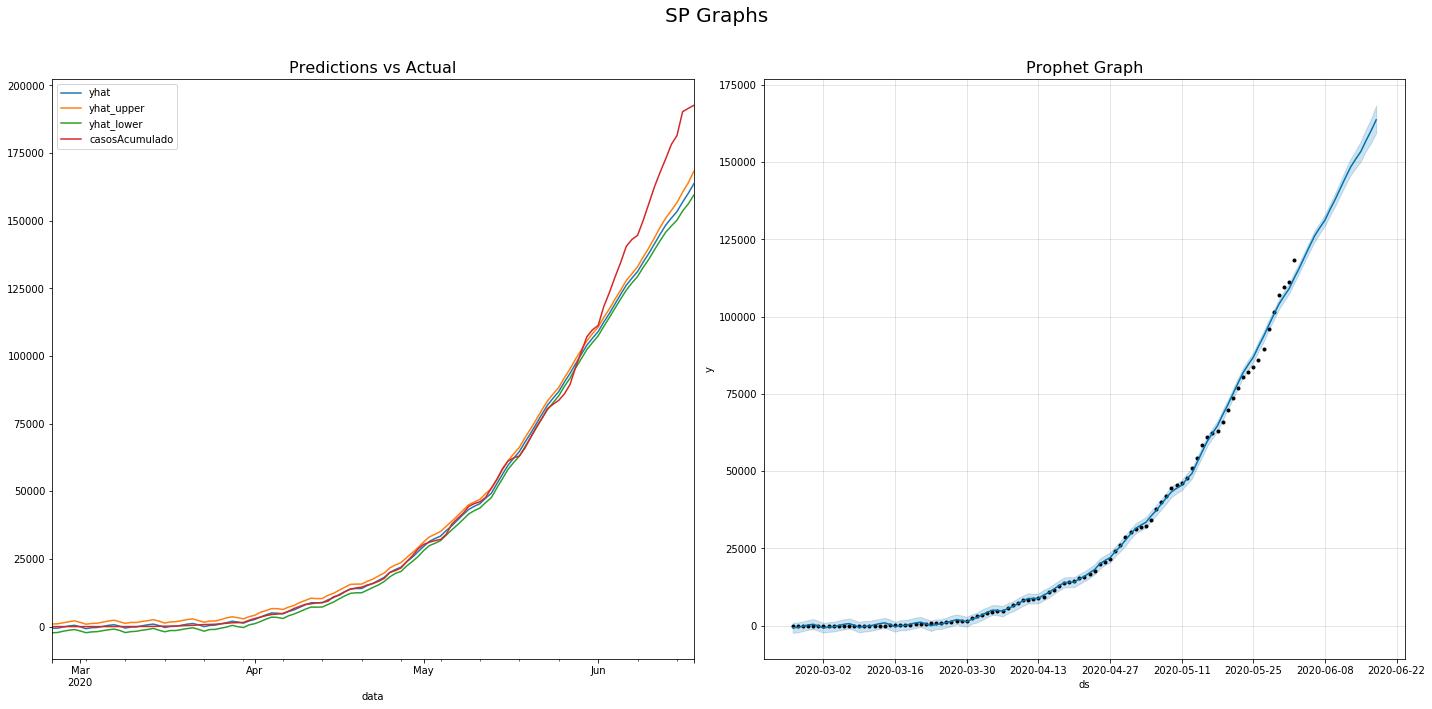

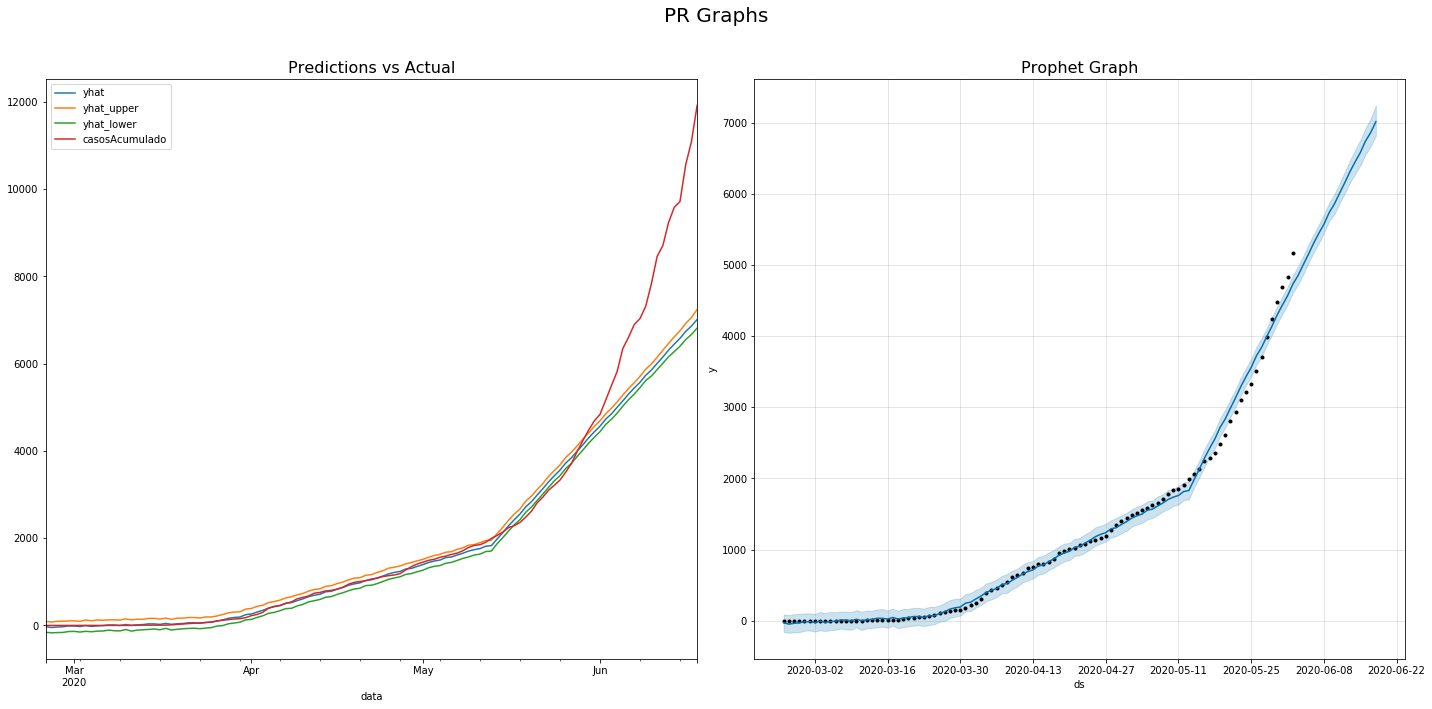

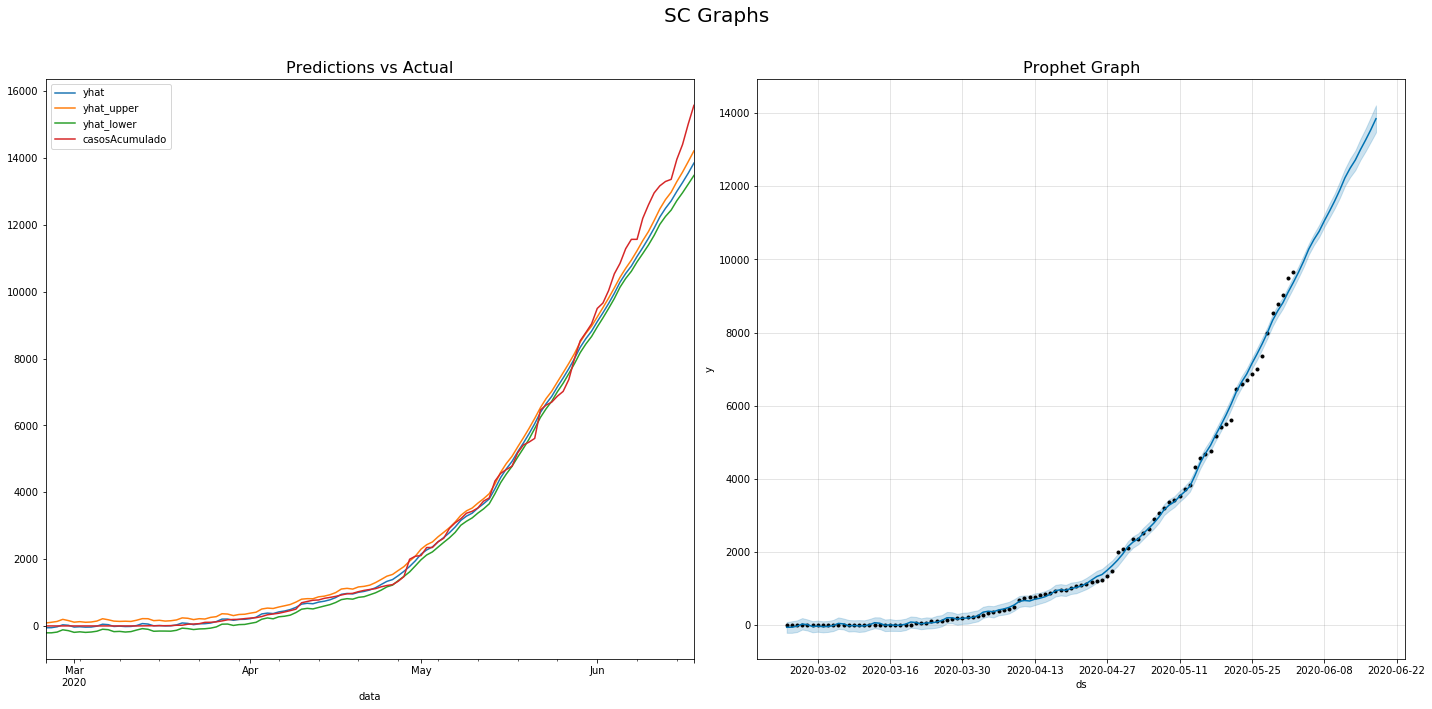

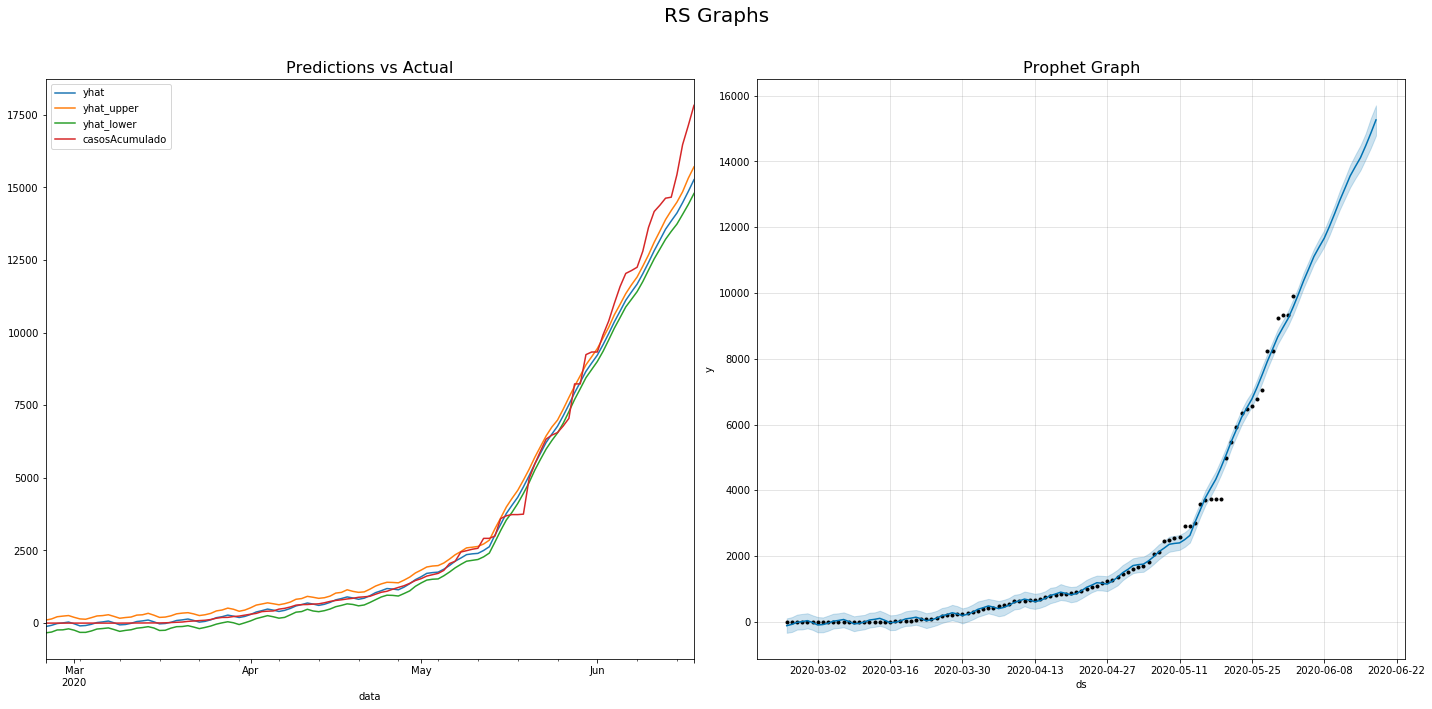

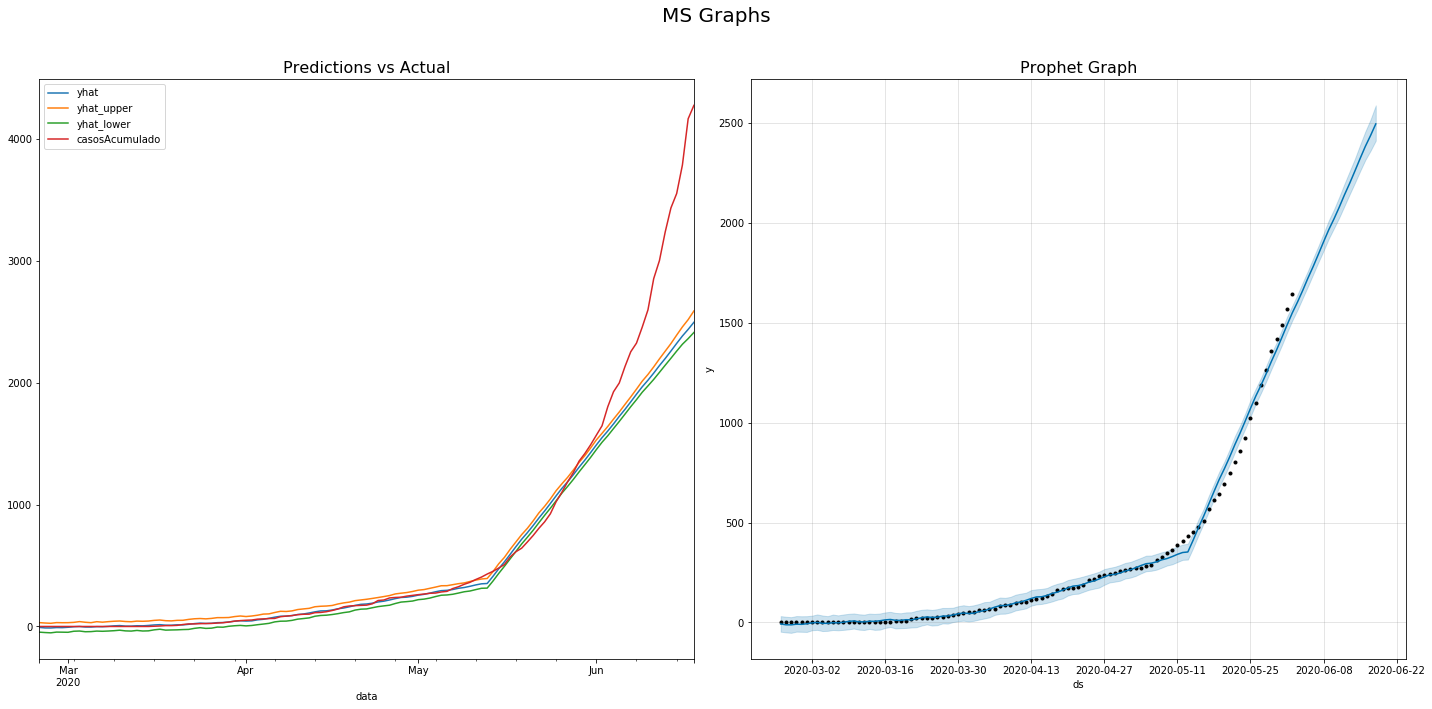

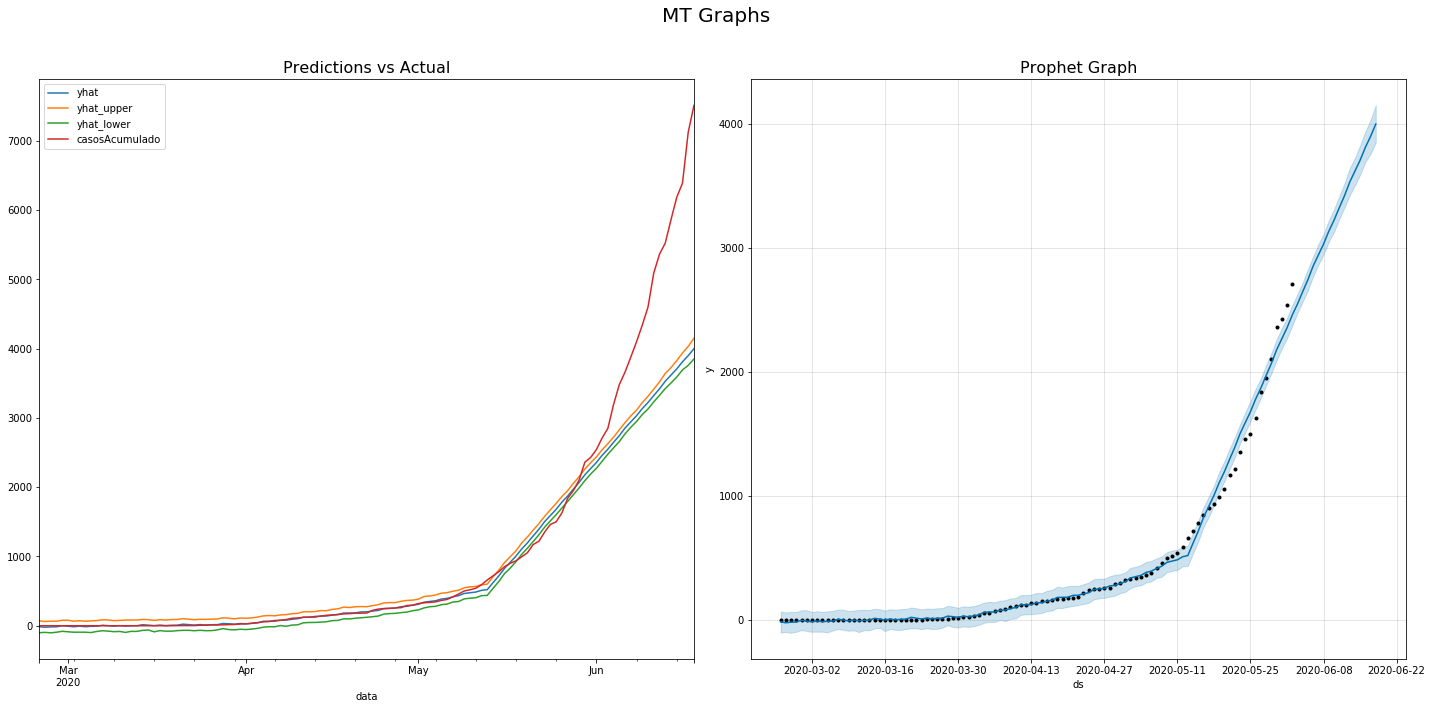

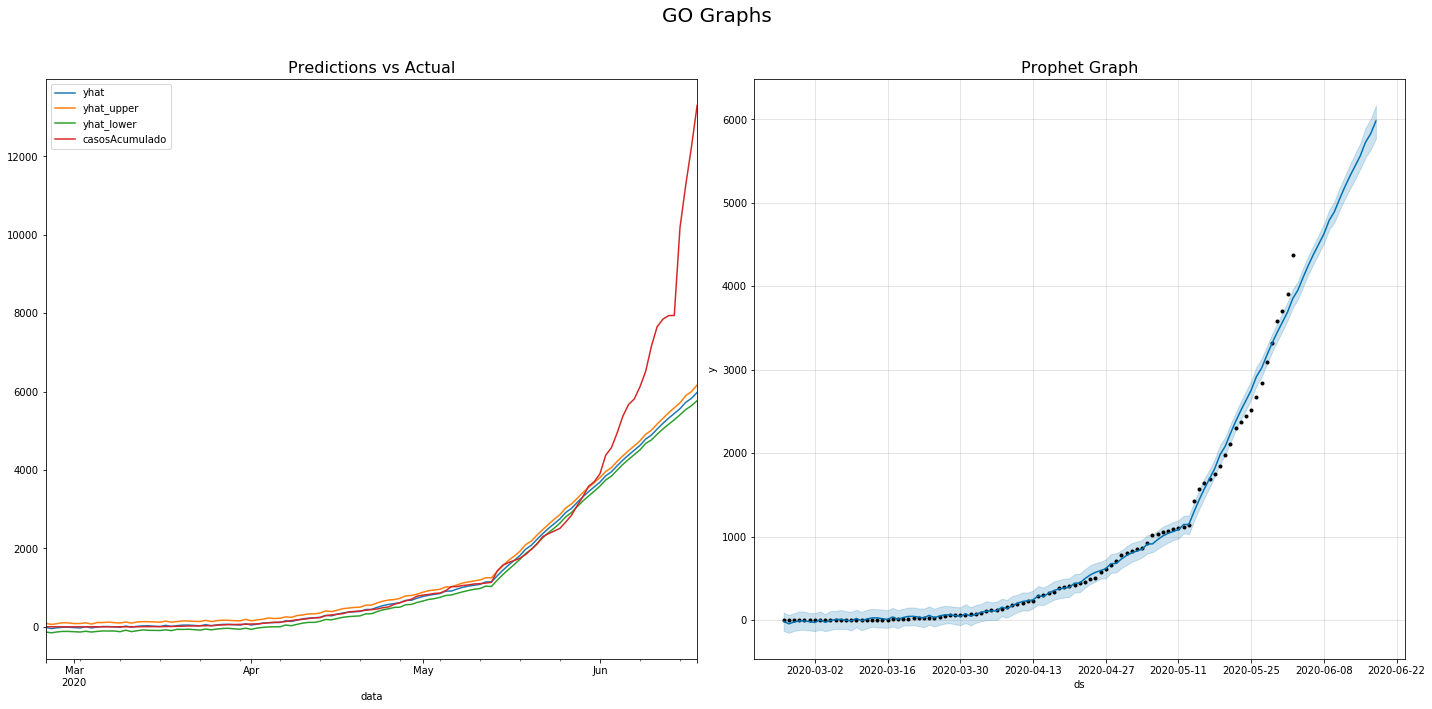

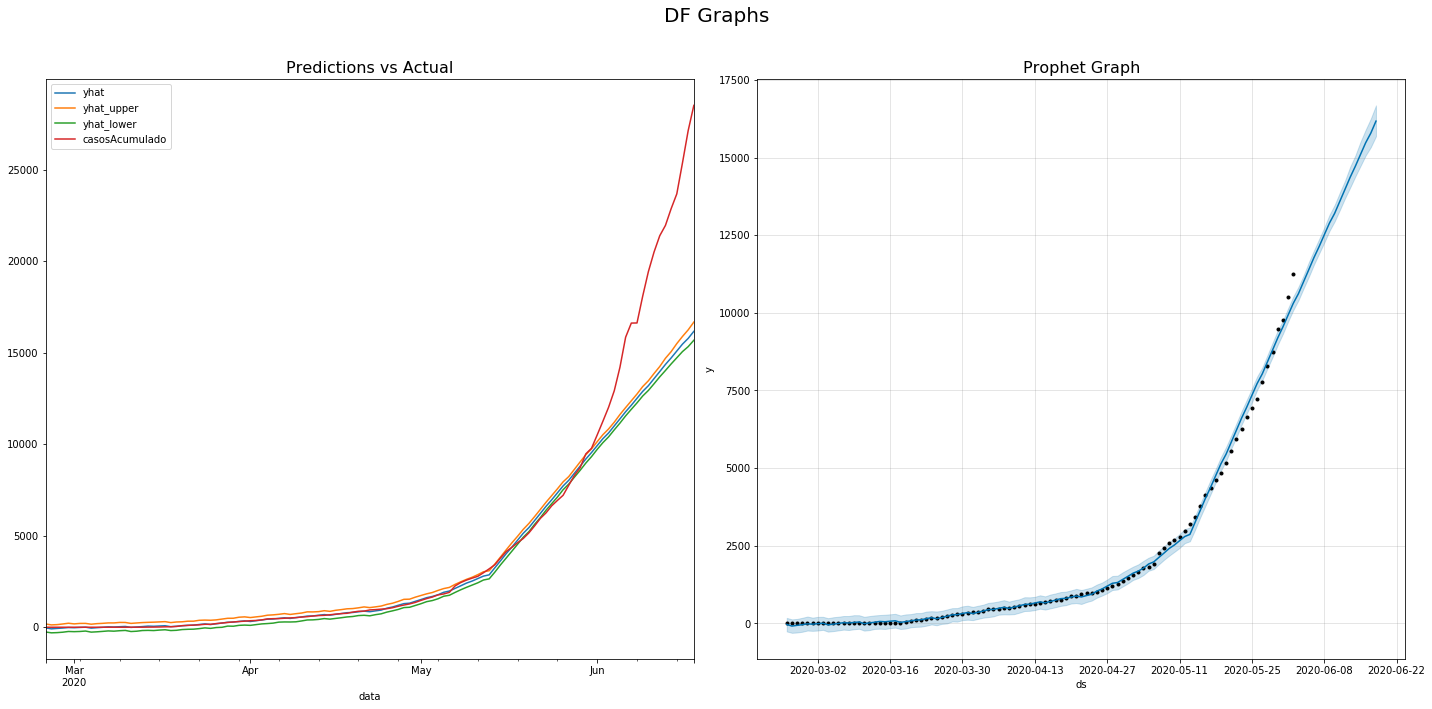

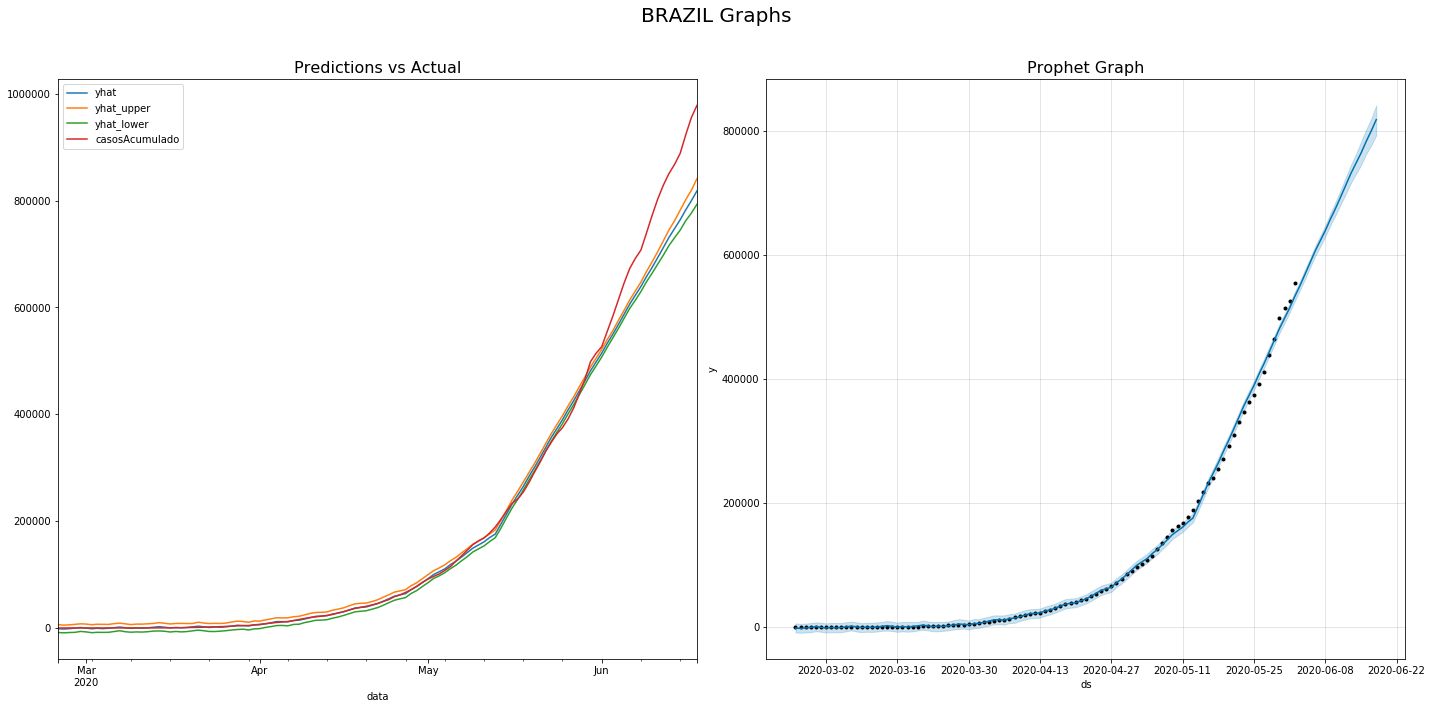

In [88]:
import numpy as np
from numpy import nan

results_df = pd.DataFrame()
states = df["estado"].unique()
states = np.append(states, "BRAZIL") # makes sure it also takes care of Brazil as a whole

for state in states[1:]: # skips over the NAN entry for Brazil
    row = run_prophet_state((df), state)
    results_df = results_df.append(row, ignore_index=True)
    

results_df.to_csv("results\prophet_results.csv", index = False) # output to file
        
        
    